In [0]:
import os

In [0]:
import quandl

In [0]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.metrics import mean_squared_error
import os

# 3. Functions

In [0]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    Based on https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    """
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    Based on https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "utopian-rush-255612-9f67682001bd.json"

In [0]:
import googleapiclient.discovery

In [0]:
project_id = "utopian-rush-255612"
model_id = "model1_20191411"
model_path = "projects/{}/models/{}".format(project_id,model_id)
ml_resource = googleapiclient.discovery.build("ml", "v1").projects()


In [0]:
def predict(X):
    input_data_json = {"signature_name": "serving_default", "instances": X.tolist()}
    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return np.array([pred['dense_2'] for pred in response["predictions"]])
    # return response["predictions"]

In [0]:
df = quandl.get("WIKI/GE")

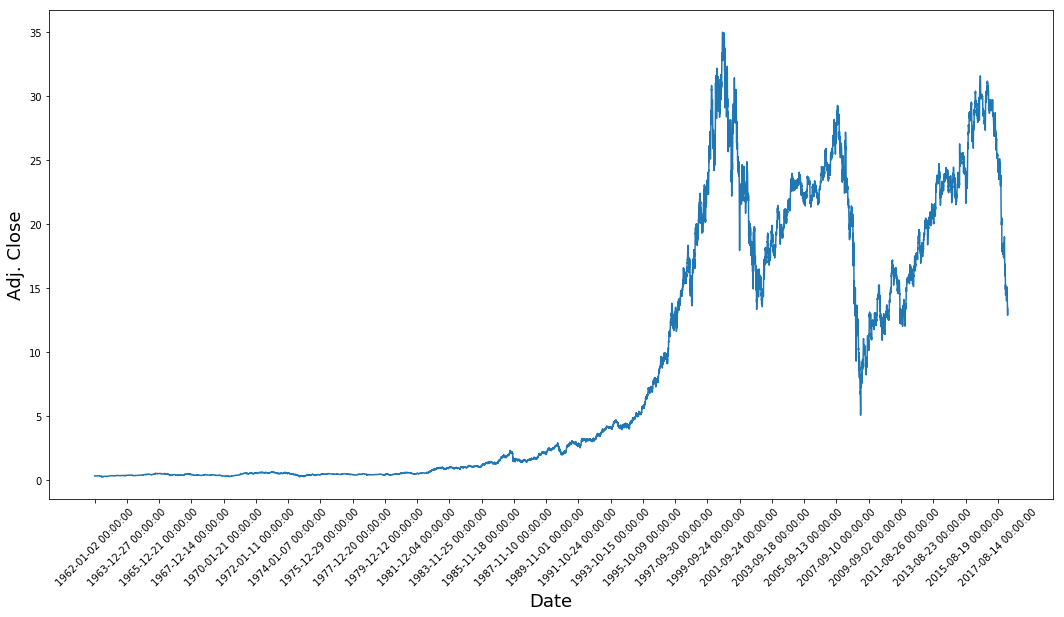

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Adj. Close']))
plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

In [0]:
# Train/Test data Split
train_cols = ["Adj. Close"]
df_train, df_test = train_test_split(df, 
                                     train_size=0.2, 
                                     test_size=0.8, 
                                     shuffle=False)
print("Train and Test size: ", len(df_train), len(df_test))

Train and Test size:  2831 11324


In [0]:
# scale the feature MinMax, build array
x = df.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(x)
X_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
# Setup Parameters
TIME_STEPS = 50
BATCH_SIZE = 20
lr = 0.0001  # Learning Rate

STEPS = 400

In [0]:
x_t, y_t = build_timeseries(X_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (14105, 50, 1) (14105,)



length of time-series i/o (11274, 50, 1) (11274,)


In [0]:
print(x_t)

[[[0.0024329 ]
  [0.00233811]
  [0.00222815]
  ...
  [0.00287524]
  [0.00289167]
  [0.00284365]]

 [[0.00233811]
  [0.00222815]
  [0.00199055]
  ...
  [0.00289167]
  [0.00284365]
  [0.00279562]]

 [[0.00222815]
  [0.00199055]
  [0.00197539]
  ...
  [0.00284365]
  [0.00279562]
  [0.00282848]]

 ...

 [[0.51510353]
  [0.52603493]
  [0.52632259]
  ...
  [0.40809095]
  [0.40348825]
  [0.40607727]]

 [[0.52603493]
  [0.52632259]
  [0.51884322]
  ...
  [0.40348825]
  [0.40607727]
  [0.40463893]]

 [[0.52632259]
  [0.51884322]
  [0.52689793]
  ...
  [0.40607727]
  [0.40463893]
  [0.39773489]]]


In [0]:
print(x_test_t.shape)

(5630, 50, 1)


In [0]:
x_input = x_test_t[:STEPS]
y_test_t = y_test_t[0:STEPS]

In [0]:
y_pred = predict(x_input)

In [0]:
print(y_pred[:15])

[[0.15996309]
 [0.16017058]
 [0.15965351]
 [0.15995425]
 [0.16050512]
 [0.16074383]
 [0.16058153]
 [0.16101652]
 [0.16147545]
 [0.1617164 ]
 [0.16143839]
 [0.16163777]
 [0.16175827]
 [0.16189215]
 [0.16195191]]


In [0]:
y_pred = y_pred.flatten()
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 7.013240328742171e-05 (400,) (400,)
[0.15996309 0.16017058 0.15965351 0.15995425 0.16050512 0.16074383
 0.16058153 0.16101652 0.16147545 0.1617164  0.16143839 0.16163777
 0.16175827 0.16189215 0.16195191]
[0.15623198 0.15623198 0.15493638 0.15428857 0.15656884 0.15687979
 0.15428857 0.15752759 0.15558418 0.15592104 0.15752759 0.16107755
 0.1614144  0.16302096 0.16302096]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[100:120])
print(y_test_t_org[100:120])

[7.30193661 7.28724359 7.27817033 7.31410335 7.3092756  7.29743676
 7.30167761 7.31639911 7.31345637 7.30966099 7.32138951 7.34486259
 7.35604514 7.33947749 7.34219283 7.3459882  7.34860772 7.36427872
 7.36233053 7.35319822]
[7.10091756 7.03252552 7.04438014 7.05532287 7.14651226 7.20396157
 7.20396157 7.19210695 7.13556953 7.10091756 7.23770164 7.24955626
 7.3179483  7.32889103 7.26049899 7.14651226 6.98693083 6.89574144
 7.00972818 7.13556953]


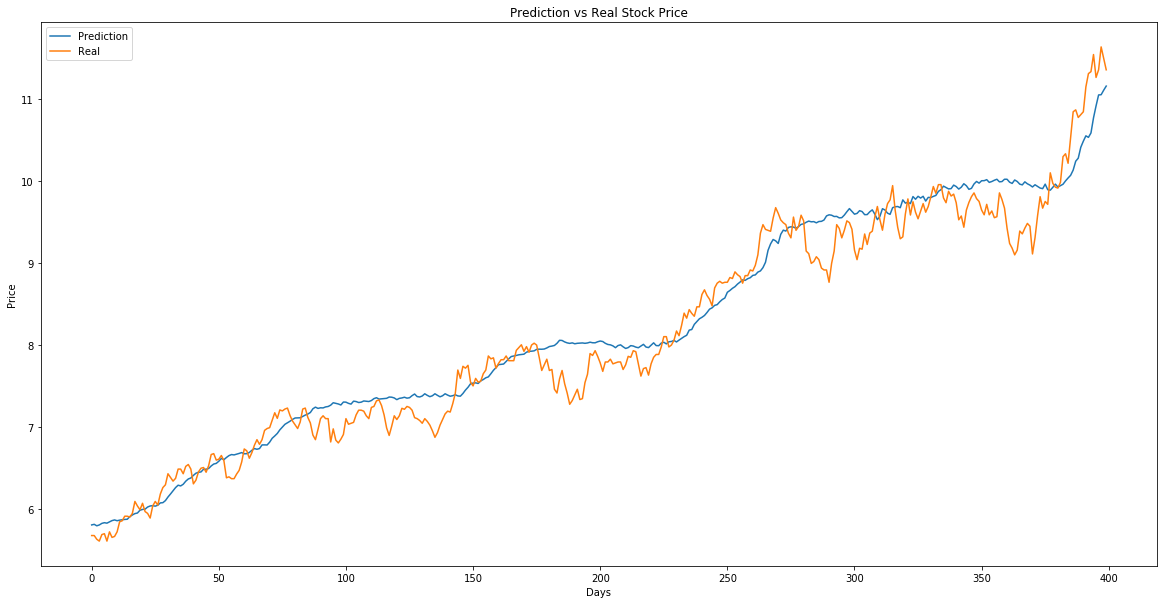

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)